In [ ]:
import time
import pandas as pd
from data import get_data
from pinn import PINN_experiment
from pinn_esc import (PINN_earlystop_experiment,PINN_patience_experiment,PINN_gradnorm_experiment,PINN_hybrid_experiment)

data = get_data()
noise = [0]
results = []

#PINN_hybrid_experiment
start = time.time()
hybrid = PINN_hybrid_experiment(data, noise, verbose=True)
time_hybrid = time.time() - start
results.append(["HybridStoppingModel", hybrid[0][0], hybrid[1][0], hybrid[2][0], round(time_hybrid, 2)])

#PINN_earlystop_experiment
start = time.time()
esc = PINN_earlystop_experiment(data, noise, rerun=True)
time_esc = time.time() - start
results.append(["EarlyStoppingCriterion", esc[0][0], esc[1][0], esc[2][0], round(time_esc, 2)])

#PINN_patience_experiment
start = time.time()
patience = PINN_patience_experiment(data, noise, rerun=True)
time_patience = time.time() - start
results.append(["PatienceStoppingModel", patience[0][0], patience[1][0], patience[2][0], round(time_patience, 2)])

#PINN_gradnorm_experiment
start = time.time()
grad = PINN_gradnorm_experiment(data, noise, verbose=True)
time_grad = time.time() - start
results.append(["GradientNormStoppingModel", grad[0][0], grad[1][0], grad[2][0], round(time_grad, 2)])

#classic pinn
start = time.time()
classic = PINN_experiment(data, noise, rerun=True)
time_classic = time.time() - start
results.append(["Classic PINN", classic[0][0], classic[1][0], classic[2][0], round(time_classic, 2)])

df = pd.DataFrame(results, columns=["Model", "RMSE", "Estimated Parameter", "Parameter Error", "Runtime (s)"])
df.to_csv("./results/pinn_comparison_results.csv", index=False)
print("\nResults saved to ./results/pinn_comparison_results.csv")


ok modules_esc
ok pinn_esc
Loaded data.


c:\Users\lenovo\Desktop\1D Burgers' equation\data.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  tensor_data.append(torch.tensor(entry))


Estimated parameter: 0.003188513055879223
Test set RMSE: 4.710309457026341e-06
Parameter error: 2.931349711702198e-11
Noise level: 0
Estimated parameter: 0.0032420853362852293
Test set RMSE: 5.1056931049988675e-06
Parameter error: 3.4794041677245903e-09
PINN early stopping test complete.
Noise level: 0
Estimated parameter: 0.0032370416459005496
Test set RMSE: 1.8401470566329257e-06
Parameter error: 2.9098239524288742e-09
PINN patience-based test complete.
Estimated parameter: 0.003322516978039284
Test set RMSE: 7.069924901831166e-06
Parameter error: 1.9437411125140587e-08
Noise level:0
Estimated parameter:0.0031523095286487596
Test set, RMSE: 4.8552730356900574e-05
[0]
[4.8552730356900574e-05]
[0.0031523095286487596]
[9.479830382323417e-10]
PINN test complete.

Results saved to ./results/pinn_comparison_results.csv


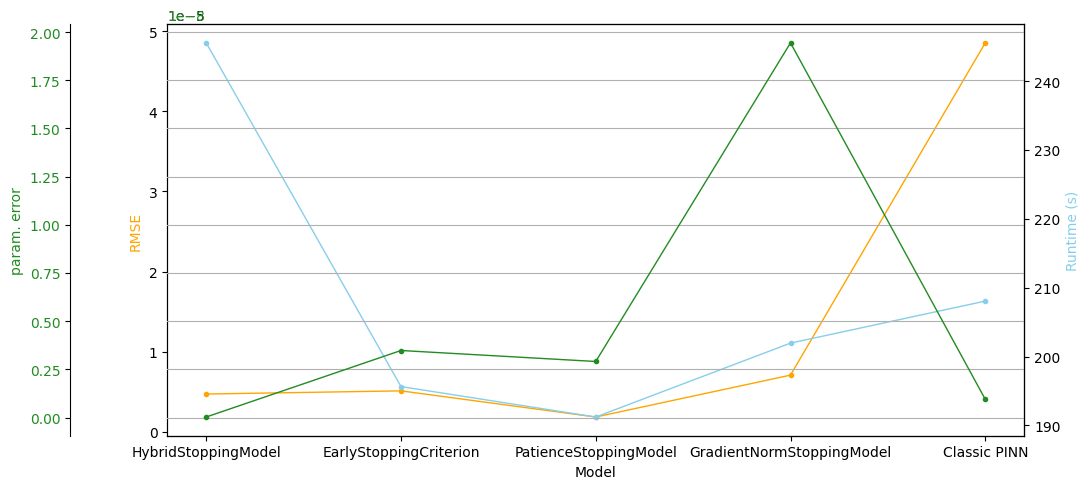

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("./results/pinn_comparison_results.csv")  
fig, ax1 = plt.subplots(figsize=(11, 5))
x = range(len(df))
model_labels = df["Model"]

color_rmse = "orange"
ax1.set_xlabel("Model", color="black")
ax1.set_ylabel("RMSE", color=color_rmse)
ax1.plot(x, df["RMSE"], marker='o', markersize=3, color=color_rmse, label="RMSE", linewidth=1)
ax1.tick_params(axis='y', labelcolor="black")
ax1.set_xticks(x)
ax1.set_xticklabels(model_labels, color="black")
ax2 = ax1.twinx()
color_runtime = "skyblue"
ax2.set_ylabel("Runtime (s)", color=color_runtime)
ax2.plot(x, df["Runtime (s)"], marker='o', markersize=3, color=color_runtime, label="Runtime", linewidth=1)
ax2.tick_params(axis='y', labelcolor="black")
ax3 = ax1.twinx()
ax3.spines["left"].set_position(("outward", 70))  
color_param = "forestgreen"
ax3.set_ylabel("param. error", color=color_param)
ax3.plot(x, df["Parameter Error"], marker='o', markersize=3, color=color_param, label="parameter error", linewidth=1)
ax3.tick_params(axis='y', labelcolor=color_param)
ax3.yaxis.set_label_position("left")
ax3.yaxis.tick_left()
fig.tight_layout()
plt.grid(True)
plt.show()

In [2]:
import time
import pandas as pd
from data import get_data, prepare_tensor, add_noise
from pinn import PINN_experiment
from pinn_esc import (PINN_earlystop_experiment,PINN_patience_experiment,PINN_gradnorm_experiment,PINN_hybrid_experiment)
from modules_esc import ( EarlyStoppingCriterion,  PatienceStoppingModel,GradientNormStoppingModel, HybridStoppingModel)
from sklearn.metrics import mean_squared_error
import numpy as np
import math

data = get_data()
noise = [0]
results = []

def run_custom_model(name, model):
    x_test, y_test, x_train, y_train, x_bc, y_bc, x_ic, y_ic, x_val, y_val, pde_x, _ = prepare_tensor(data)
    y_train_noise, y_val_noise = add_noise([y_train, y_val], noise_level=noise[0])
    start = time.time()
    model.train_model([x_bc, y_bc], [x_ic, y_ic], [x_train, y_train_noise], [x_val, y_val_noise], pde_x, iterations=2000)
    elapsed = time.time() - start
    pred = model.forward(x_test)
    rmse = mean_squared_error(pred.detach(), y_test.reshape(-1, 1))
    param = 10 ** model.visc.item()
    param_error = mean_squared_error([param], [0.01 / math.pi])
    results.append([f"BestHyp_{name}", rmse, param, param_error, round(elapsed, 2)])

data = get_data()
noise = [0]
results = []

#same models with the best hyperparameters
run_custom_model("EarlyStoppingCriterion", EarlyStoppingCriterion(target_rmse=9.4e-7,target_param_error=1.6e-5))
run_custom_model("PatienceStoppingModel", PatienceStoppingModel(patience=20,min_delta=7.4e-5))
run_custom_model("GradientNormStoppingModel", GradientNormStoppingModel(grad_threshold=1.9e-5))
run_custom_model("HybridStoppingModel", HybridStoppingModel(patience=43,min_delta=4.1e-4,slope_threshold=5.6e-5,grad_threshold=4.7e-5))

#PINN_hybrid_experiment
start = time.time()
hybrid = PINN_hybrid_experiment(data, noise, verbose=True)
time_hybrid = time.time() - start
results.append(["HybridStoppingModel", hybrid[0][0], hybrid[1][0], hybrid[2][0], round(time_hybrid, 2)])

#PINN_earlystop_experiment
start = time.time()
esc = PINN_earlystop_experiment(data, noise, rerun=True)
time_esc = time.time() - start
results.append(["EarlyStoppingCriterion", esc[0][0], esc[1][0], esc[2][0], round(time_esc, 2)])

#PINN_patience_experiment
start = time.time()
patience = PINN_patience_experiment(data, noise, rerun=True)
time_patience = time.time() - start
results.append(["PatienceStoppingModel", patience[0][0], patience[1][0], patience[2][0], round(time_patience, 2)])

#PINN_gradnorm_experiment
start = time.time()
grad = PINN_gradnorm_experiment(data, noise, verbose=True)
time_grad = time.time() - start
results.append(["GradientNormStoppingModel", grad[0][0], grad[1][0], grad[2][0], round(time_grad, 2)])

#classic pinn
start = time.time()
classic = PINN_experiment(data, noise, rerun=True)
time_classic = time.time() - start
results.append(["Classic PINN", classic[0][0], classic[1][0], classic[2][0], round(time_classic, 2)])


df = pd.DataFrame(results, columns=["Model", "RMSE", "Estimated Parameter", "Parameter Error", "Runtime (s)"])
df.to_csv("./results/pinn_two_types_esc_results.csv", index=False)
print("\nResults saved to ./results/pinn_two_types_esc_results.csv")

ok modules_esc
ok pinn_esc
Loaded data.
Loaded data.


c:\Users\lenovo\Desktop\1D Burgers' equation\data.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  tensor_data.append(torch.tensor(entry))


Patience stopping at iteration 53
Estimated parameter: 0.0032002783231152017
Test set RMSE: 3.554461015440595e-06
Parameter error: 2.9513388977806295e-10
Noise level: 0
Estimated parameter: 0.003197921450660457
Test set RMSE: 1.5909467105295594e-06
Parameter error: 2.1970913940238476e-10
PINN early stopping test complete.
Patience stopping at iteration 305
Noise level: 0
Estimated parameter: 0.003509331770772956
Test set RMSE: 1.5293221317031505e-05
Parameter error: 1.0642791087222386e-07
PINN patience-based test complete.
Estimated parameter: 0.003253957174075261
Test set RMSE: 8.06488600155874e-06
Parameter error: 5.02090041312636e-09
Noise level:0
Estimated parameter:0.0031252840661168024
Test set, RMSE: 3.81595317566222e-05
[0]
[3.81595317566222e-05]
[0.0031252840661168024]
[3.3425506042730632e-09]
PINN test complete.

Results saved to ./results/pinn_two_types_esc_results.csv


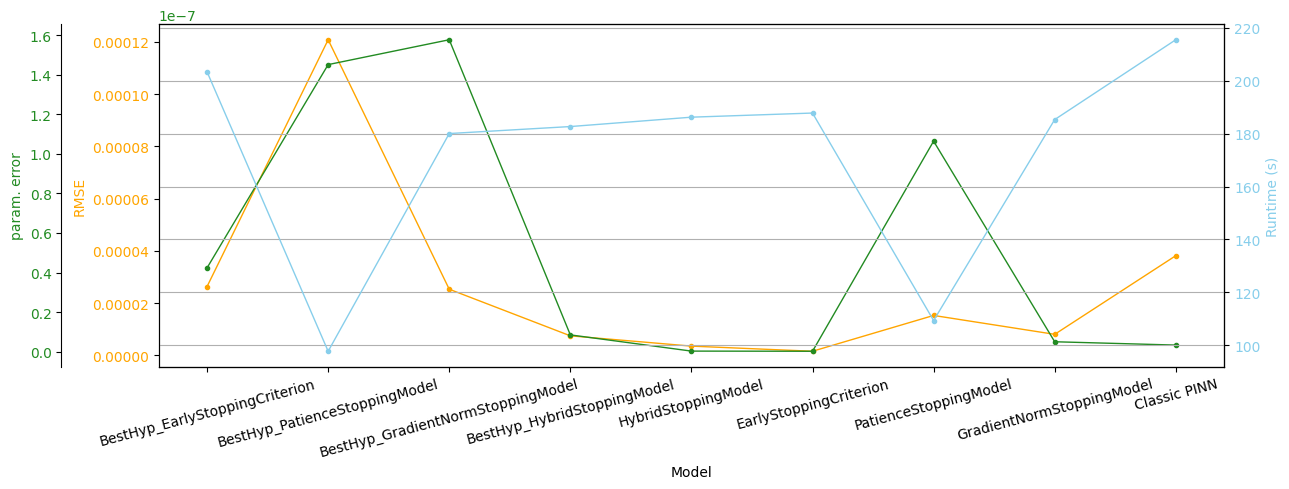

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("./results/pinn_two_types_esc_results.csv")  
fig, ax1 = plt.subplots(figsize=(13, 5))
x = range(len(df))
model_labels = df["Model"]


color_rmse = "orange"
ax1.set_xlabel("Model", color="black")
ax1.set_ylabel("RMSE", color=color_rmse)
ax1.plot(x, df["RMSE"], marker='o', markersize=3, color=color_rmse, label="RMSE", linewidth=1)
ax1.tick_params(axis='y', labelcolor=color_rmse)
ax1.set_xticks(x)
ax1.set_xticklabels(model_labels, color="black", rotation=15)

ax3 = ax1.twinx()
ax3.spines["left"].set_position(("outward", 70))  
color_param = "forestgreen"
ax3.set_ylabel("param. error", color=color_param)
ax3.plot(x, df["Parameter Error"], marker='o', markersize=3, color=color_param, label="parameter error", linewidth=1)
ax3.tick_params(axis='y', labelcolor=color_param)
ax3.yaxis.set_label_position("left")
ax3.yaxis.tick_left()

ax2 = ax1.twinx()
color_runtime = "skyblue"
ax2.set_ylabel("Runtime (s)", color=color_runtime)
ax2.plot(x, df["Runtime (s)"], marker='o', markersize=3, color=color_runtime, label="Runtime", linewidth=1)
ax2.tick_params(axis='y', labelcolor=color_runtime)
fig.tight_layout()
plt.grid(True)
plt.show()


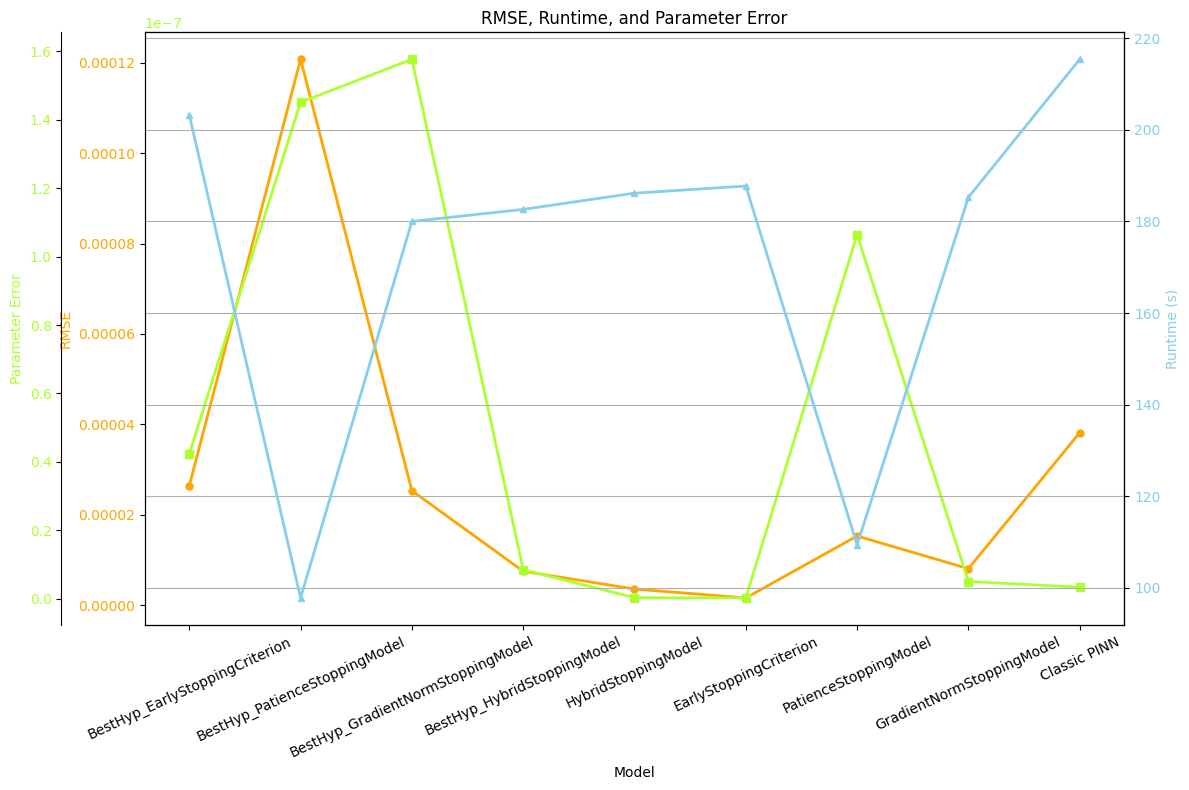

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("./results/pinn_two_types_esc_results.csv")  
fig, ax1 = plt.subplots(figsize=(12, 8))  # Increased height
x = range(len(df))
model_labels = df["Model"]

# RMSE on left (primary)
color_rmse = "orange"
ax1.set_xlabel("Model", color="black")
ax1.set_ylabel("RMSE", color=color_rmse)
ax1.plot(x, df["RMSE"], marker='o', markersize=5, color=color_rmse, label="RMSE", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color_rmse)
ax1.set_xticks(x)
ax1.set_xticklabels(model_labels, color="black", rotation=25)

# Parameter Error on secondary left axis (stacked)
ax3 = ax1.twinx()
ax3.spines["left"].set_position(("outward", 60))  # Offset the second left axis
color_param = "greenyellow"
ax3.set_ylabel("Parameter Error", color=color_param)
ax3.plot(x, df["Parameter Error"], marker='s', markersize=6, color=color_param, label="Parameter Error", linewidth=2)
ax3.tick_params(axis='y', labelcolor=color_param)
ax3.yaxis.set_label_position("left")
ax3.yaxis.tick_left()

# Runtime on right
ax2 = ax1.twinx()
color_runtime = "skyblue"
ax2.set_ylabel("Runtime (s)", color=color_runtime)
ax2.plot(x, df["Runtime (s)"], marker='^', markersize=5, color=color_runtime, label="Runtime", linewidth=2)
ax2.tick_params(axis='y', labelcolor=color_runtime)

# Title and layout
plt.title("RMSE, Runtime, and Parameter Error", color="black")
fig.tight_layout()
plt.grid(True)
plt.show()
